In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from scipy.stats import spearmanr, pearsonr

# Introduction

We aim to analyze the relationship between species abundance (X) and gene coverages (Y) using a linear regression model:

$$
Y = \alpha X + \epsilon
$$

where:

$
X \in \mathbb{R}^{S \times N}, \quad \text{species abundances (S species, N samples)}
$

$
Y \in \mathbb{R}^{G \times N}, \quad \text{gene coverages (G genes, N samples)}
$

$
\alpha \in \mathbb{R}^{G \times S}, \quad \text{influence matrix capturing linear effects of species on genes}
$

$
\epsilon \in \mathbb{R}^{G \times N}, \quad \text{residuals representing unexplained variation}
$


The linear model captures **direct relationships** between species and genes. However, **non-linear dependencies** (e.g., species interactions or environmental effects) remain in the residuals $(\epsilon)$. By analyzing $\epsilon$, we aim to uncover **complex, non-linear patterns** driving gene expression.

# Load Data

In [2]:
# import data
df_species = pd.read_parquet('../processed_data/taxon_coverage_s.parquet')

df_genes   = pd.read_parquet('../processed_data/gene_coverage.parquet')
df_genes = df_genes.set_index("Sample")

# match indexes
df_species = df_species.reindex(df_genes.index)

# Data Processing

In [3]:
count_species = (df_species > 0).sum(0)
count_genes = (df_genes > 0).sum(0)

# remove columns that rarely show up
threshold = 100

species_keep = count_species[count_species >= threshold].index
genes_keep = count_genes[count_genes >= threshold].index

print(f'Keeping {species_keep.shape[0]} Species and {genes_keep.shape[0]} Genes')

df_species = df_species[species_keep]
df_genes = df_genes[genes_keep]

del species_keep
del genes_keep

Keeping 160 Species and 277213 Genes


# Linear Regression

In [4]:
# Slow
# X = np.array(df_species.values).T
# Y = np.array(df_genes.values).T
# 
# Xt = X.T
# alpha = Y @ Xt @ np.linalg.pinv(X @ Xt)
# 
# alpha.shape

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_torch = torch.tensor(df_species.values.T, dtype=torch.float32, device=device)  # (n_features, n_samples)

Y_np = df_genes.values.T
Y_sparse = torch.tensor(Y_np, dtype=torch.float32, device=device)
Y_sparse = Y_sparse.to_sparse()  # convert to sparse format

Xt_torch = X_torch.T  # (n_samples, n_features)

alpha_torch = Y_sparse @ Xt_torch @ torch.linalg.pinv(X_torch @ Xt_torch)
alpha = alpha_torch.to_dense().cpu().numpy()

del X_torch, Y_np, Y_sparse

Using device: cuda


## Residuals

In [6]:
X_torch = torch.tensor(df_species.values.T, dtype=torch.float32, device=device)
Y_torch = torch.tensor(df_genes.values.T, dtype=torch.float32, device=device)

Y_hat = alpha_torch @ X_torch
residuals = Y_torch - Y_hat

SSE = torch.sum(residuals ** 2, dim=1)

SSE_cpu = SSE.cpu().numpy()

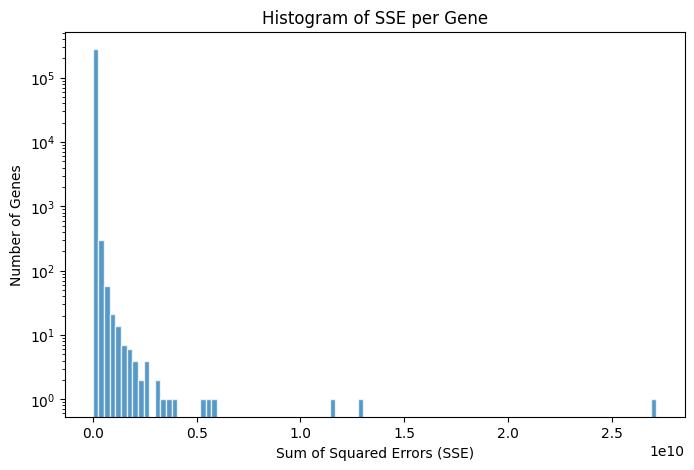

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(SSE_cpu, bins=100, alpha=0.75, edgecolor='white', log=True)
plt.xlabel("Sum of Squared Errors (SSE)")
plt.ylabel("Number of Genes")
plt.title("Histogram of SSE per Gene")
plt.show()

# Effect on Samples' Gene Similarity

In [8]:
residuals.shape

torch.Size([277213, 2690])

Using device: cuda


/tmp/slurm-4035282/ipykernel_1632623/1381301208.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(data, dtype=torch.float32, device=device)


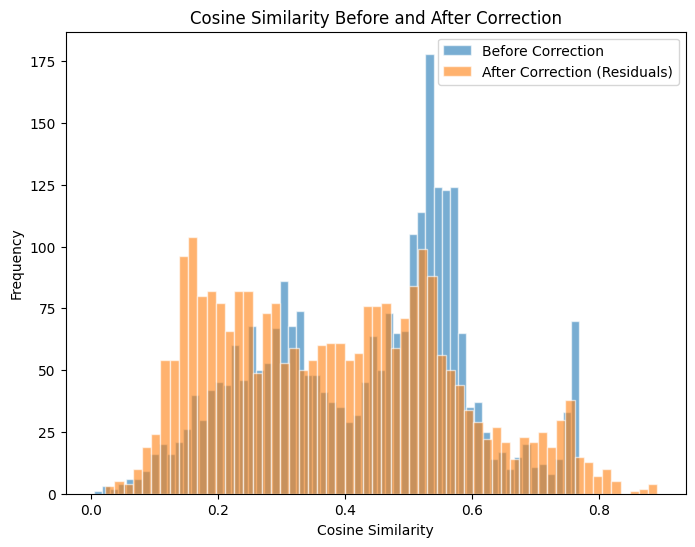

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def compute_cosine_similarity(data):
    """Computes cosine similarity between each sample and the mean vector."""
    tensor = torch.tensor(data, dtype=torch.float32, device=device)
    
    # Truncate negatives to 0 if needed
    tensor = torch.clamp(tensor, min=0)  
    
    # Compute mean vector
    mean_vector = tensor.mean(dim=0)
    
    # Normalize for cosine similarity
    tensor_norm = tensor / torch.norm(tensor, dim=1, keepdim=True)
    mean_vector_norm = mean_vector / torch.norm(mean_vector)
    
    # Compute cosine similarity
    cosine_similarities = torch.mm(tensor_norm, mean_vector_norm.unsqueeze(1)).squeeze()
    
    return cosine_similarities.cpu().numpy()

# Compute cosine similarity for original data
cosine_similarities = compute_cosine_similarity(df_genes.values)

# Compute cosine similarity for residuals
cosine_similarities_residuals = compute_cosine_similarity(residuals.T)

# Plot both histograms on the same figure
plt.figure(figsize=(8, 6))
plt.hist(cosine_similarities, edgecolor='white', bins=60, alpha=0.6, label='Before Correction')
plt.hist(cosine_similarities_residuals, edgecolor='white', bins=60, alpha=0.6, label='After Correction (Residuals)')
plt.legend()
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Before and After Correction')
plt.show()

# Residuals Exploration

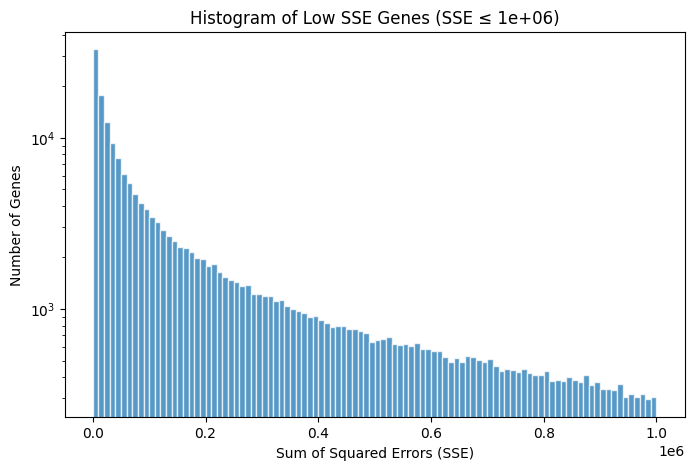

In [7]:
low_sse_threshold = 1e6
low_sse = SSE[SSE <= low_sse_threshold]

plt.figure(figsize=(8, 5))
plt.hist(low_sse, bins=100, alpha=0.75, edgecolor='white', log=True)
plt.xlabel("Sum of Squared Errors (SSE)")
plt.ylabel("Number of Genes")
plt.title(f"Histogram of Low SSE Genes (SSE ≤ {low_sse_threshold:.0e})")
plt.show()

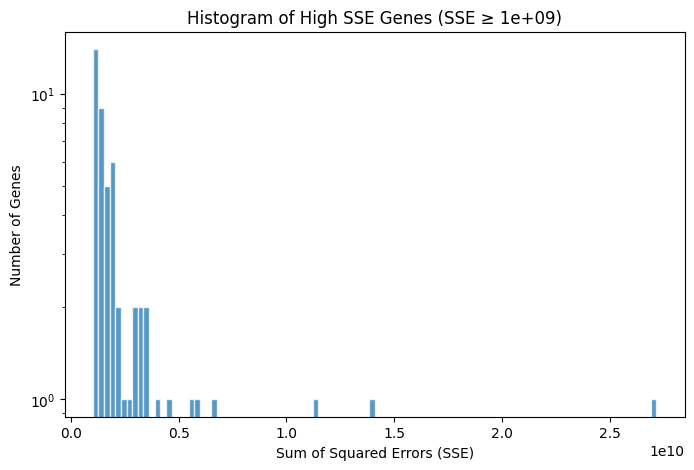

In [8]:
high_sse_threshold = 1e9
high_sse = SSE[SSE >= high_sse_threshold]

plt.figure(figsize=(8, 5))
plt.hist(high_sse, bins=100, alpha=0.75, edgecolor='white', log=True)
plt.xlabel("Sum of Squared Errors (SSE)")
plt.ylabel("Number of Genes")
plt.title(f"Histogram of High SSE Genes (SSE ≥ {high_sse_threshold:.0e})")
plt.show()

In [9]:
log_SSE = np.log(SSE)

sse_df = pd.DataFrame({
    "Gene": df_genes.columns,
    "Log_SSE": log_SSE
})

In [10]:
sse_df.sort_values(by='Log_SSE', ascending=False).head(10).values

array([['MGYG000148864_331_1', 24.02543322038464],
       ['MGYG000005720.fa_46_2', 23.3525239826905],
       ['MGYG000051475_5_18', 23.16292763125974],
       ['MGYG000005615.fa_1_18', 22.600361185484246],
       ['MGYG000207250_6_74', 22.504517455315582],
       ['MGYG000158458_132_5', 22.464552753041595],
       ['MGYG000043502_12_1', 22.24704236162202],
       ['MGYG000100326_38_1', 22.082318113741884],
       ['MGYG000159867_39_3', 21.958956125230504],
       ['MGYG000051077_1_1346', 21.940577440262153]], dtype=object)

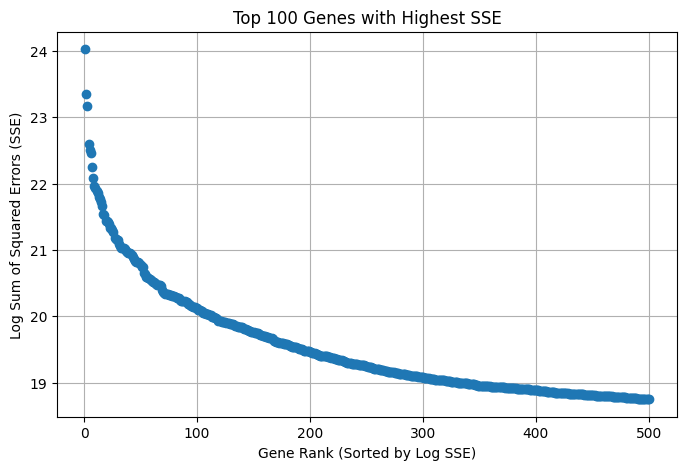

In [11]:
n_genes = 500

# genes with the highest log SSE
top_100_genes = sse_df.sort_values(by="Log_SSE", ascending=False).head(n_genes)

plt.figure(figsize=(8, 5))
plt.scatter(np.linspace(1, n_genes, n_genes), 
            top_100_genes["Log_SSE"],
            zorder=10000)

plt.xlabel("Gene Rank (Sorted by Log SSE)")
plt.ylabel("Log Sum of Squared Errors (SSE)")
plt.title("Top 100 Genes with Highest SSE")
plt.grid(True, zorder=1)
plt.show()

### Is there a correlation between number of gene ocurrences and the log(SSE)?

Pearson Correlation: 0.2800
Spearman Correlation: 0.2662


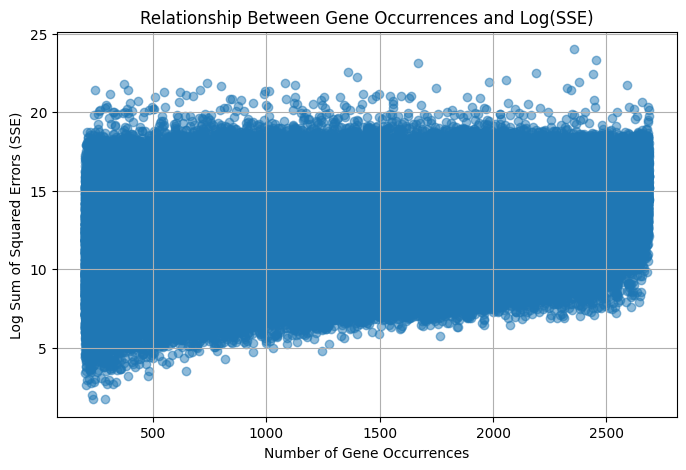

In [12]:
gene_occurrences = (df_genes > 0).sum(axis=0)
sse_df["Occurrences"] = gene_occurrences.values

pearson_corr, _ = pearsonr(sse_df["Occurrences"], sse_df["Log_SSE"])
spearman_corr, _ = spearmanr(sse_df["Occurrences"], sse_df["Log_SSE"])

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(sse_df["Occurrences"], sse_df["Log_SSE"], alpha=0.5)
plt.xlabel("Number of Gene Occurrences")
plt.ylabel("Log Sum of Squared Errors (SSE)")
plt.title("Relationship Between Gene Occurrences and Log(SSE)")
plt.grid(True)
plt.show()

The genes with the highest SSE are not simply those that are rare or frequent.

# Analysis of $\alpha$

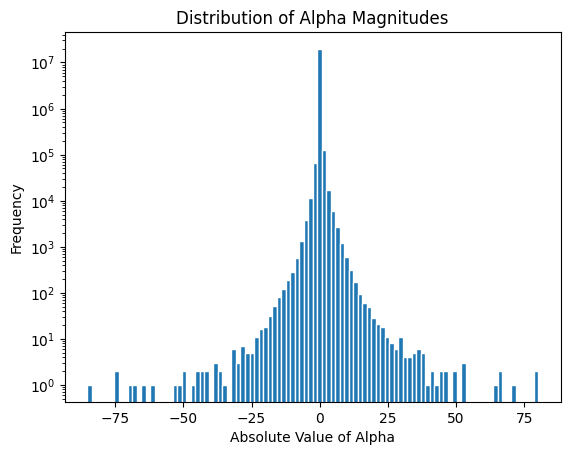

In [13]:
plt.hist(alpha.flatten(), bins=100, edgecolor='white')
plt.xlabel("Absolute Value of Alpha")
plt.ylabel("Frequency")
plt.title("Distribution of Alpha Magnitudes")
plt.yscale('log')
plt.show()

In [28]:
# average ABSOLUTE alpha value per species
avg_alpha_per_species = np.mean(np.abs(alpha), axis=0)  # mean over genes
species_occurrence_percentage = (df_species > 0).mean(axis=0).values * 100

species_contribution_df = pd.DataFrame({
    "Species": df_species.columns,
    "Avg_Alpha": avg_alpha_per_species,
    "Species_Occurrence_Percentage": species_occurrence_percentage
})

species_contribution_df.sort_values(by="Avg_Alpha", ascending=False).head(20)

,Species,Avg_Alpha,Species_Occurrence_Percentage
28,Enterocloster clostridioformis,0.458548,13.011152
27,Ruminococcus_B sp900544395,0.376772,8.141264
69,Lactobacillus sp944327175,0.340027,9.702602
52,Agathobaculum butyriciproducens,0.279349,7.509294
70,Lactobacillus delbrueckii,0.268449,10.000000
66,Bacillus subtilis,0.199819,9.479554
73,Pseudomonas_E putida,0.198146,9.405204
57,Rothia sp902373285,0.184292,8.996283
30,Anaerostipes caccae,0.156947,7.657993
13,Streptococcus sp934229725,0.148796,14.832714


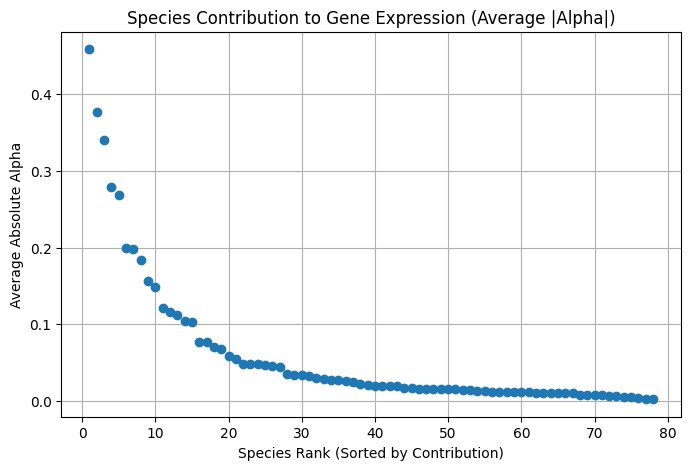

In [15]:
plt.figure(figsize=(8, 5))
plt.scatter(np.linspace(1, species_contribution_df.shape[0], species_contribution_df.shape[0]), 
            species_contribution_df.sort_values(by="Avg_Alpha", ascending=False)["Avg_Alpha"],
            zorder=10000)

plt.xlabel("Species Rank (Sorted by Contribution)")
plt.ylabel("Average Absolute Alpha")
plt.title("Species Contribution to Gene Expression (Average |Alpha|)")
plt.grid(True, zorder=1)
plt.show()